This notebook sweeps the SMU Keithley 2450, based on Joe's dummy instruments demo

In [1]:
import time
import numpy as np
import qcodes as qc
from qcodes.dataset.measurements import Measurement
from qcodes.instrument_drivers.tektronix.Keithley_2450 import Keithley_2450
from qcodes.tests.instrument_mocks import DummyInstrument
from qcodes.dataset.database import initialise_or_create_database_at

Now we will create an instance of the class Keithley

In [2]:
Keith = Keithley_2450('Keith', 'USB0::0x05E6::0x2450::04358606::INSTR')

First a test to see that the Keithley 2450 works

In [6]:
Keith.rangev(20)
Keith.volt(1)
c=Keith.curr()
#x=Keith.sense()

2.581466E-12


In [7]:
initialise_or_create_database_at('C:\\Users\\nanouser\\MeasureIt\\currentdatabase.db')

Start a new experiment that will go in "currentdatabase"

In [8]:
qc.new_experiment(name='demotest3', sample_name='my best sample3')

demotest3#my best sample3#1@C:\Users\nanouser\MeasureIt\currentdatabase.db
--------------------------------------------------------------------------

Class Sweep to sweep and then plots the data, should work for any intrument

In [9]:
# %load sweep.py
import io
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import qcodes as qc
from qcodes.dataset.measurements import Measurement
from IPython import display


class Sweep(object):
    def __init__(self):
        self._params = []
    
    def follow_param(self, p):
        self._params.append(p)

    def _create_measurement(self, *set_params):
        meas = Measurement()
        for p in set_params:
            meas.register_parameter(p)
        meas.register_custom_parameter('time', label='Time', unit='s')
        for p in self._params:
            meas.register_parameter(p, setpoints=(*set_params, 'time',))
        return meas
    
    def sweep(self, set_param, vals, inter_delay=None):
        if inter_delay is not None:
            d = len(vals)*inter_delay
            h, m, s = int(d/3600), int(d/60) % 60, int(d) % 60
            print(f'Minimum duration: {h}h {m}m {s}s')

        fig = plt.figure(figsize=(4*(2 + len(self._params)),4))
        grid = plt.GridSpec(4, 1 + len(self._params), hspace=0)
        setax = fig.add_subplot(grid[:, 0])
        setax.set_xlabel('Time (s)')
        setax.set_ylabel(f'{set_param.label} ({set_param.unit})')
        setaxline = setax.plot([], [])[0]

        paxs = []
        plines = []
        for i, p in enumerate(self._params):
            ax = fig.add_subplot(grid[:, 1 + i])
            ax.set_xlabel(f'{set_param.label} ({set_param.unit})')
            ax.set_ylabel(f'{p.label} ({p.unit})')
            paxs.append(ax)
            plines.append(ax.plot([], [])[0])

        laxs = []
        llines = []


        fig.tight_layout()
        fig.show()

        meas = self._create_measurement(set_param)
        with meas.run() as datasaver:
            try:
                t0 = time.monotonic()
                for setpoint in vals:
                    t = time.monotonic() - t0
                    set_param.set(setpoint)

                    setaxline.set_xdata(np.append(setaxline.get_xdata(), t))
                    setaxline.set_ydata(np.append(setaxline.get_ydata(), setpoint))
                    setax.relim()
                    setax.autoscale_view()

                    if inter_delay is not None:
                        plt.pause(inter_delay)

                    data = [
                        (set_param, setpoint),
                        ('time', t)
                        ]
                    for i, p in enumerate(self._params):
                        v = p.get()
                        data.append((p, v))
                        plines[i].set_xdata(np.append(plines[i].get_xdata(), setpoint))
                        plines[i].set_ydata(np.append(plines[i].get_ydata(), v))
                        paxs[i].relim()
                        paxs[i].autoscale_view()

                    datasaver.add_result(*data)

                    fig.tight_layout()
                    fig.canvas.draw()
                    plt.pause(0.001)

                d = time.monotonic() - t0
                h, m, s = int(d/3600), int(d/60) % 60, int(d) % 60
                print(f'Completed in: {h}h {m}m {s}s')

                b = io.BytesIO()
                fig.savefig(b, format='png')
                display.display(display.Image(data=b.getbuffer(), format='png'))
            except KeyboardInterrupt:
                print('At stoppage')
                for i,p in enumerate(data): 
                    print(data[i][0],'is equal to',data[i][1])                   
                pass

This sets data to be plotted in a separate window from the notebook

In [10]:
%matplotlib qt

Creates an instance of the class sweep <br>
Adds the parameter to measure <br>
Runs the function sweep with voltages as the sweep parameter

Minimum duration: 0h 0m 0s
Starting experimental run with id: 1
2.859945E-12
2.595404E-12
2.825137E-12
2.567558E-12
3.013101E-12
2.198593E-12
3.291565E-12
5.138819E-13
2.741599E-12
6.152604E-12
3.409913E-12
3.897225E-12
1.099042E-11
3.570030E-12
4.029496E-12
8.480421E-13
2.553635E-12
2.915639E-12
6.932222E-12
3.082718E-12
3.549146E-12
3.611800E-12
2.463135E-12
2.943485E-12
2.825138E-12
3.096642E-12
2.992218E-12
2.971332E-12
2.922601E-12
2.504906E-12
2.811216E-12
2.630213E-12
2.964371E-12
2.671983E-12
2.163787E-12
2.177710E-12
2.435289E-12
2.511866E-12
3.061834E-12
3.228912E-12
2.971333E-12
2.811217E-12
3.430799E-12
2.894755E-12
3.521300E-12
2.859948E-12
2.553639E-12
2.581484E-12
2.588445E-12
3.020064E-12
Completed in: 0h 0m 10s


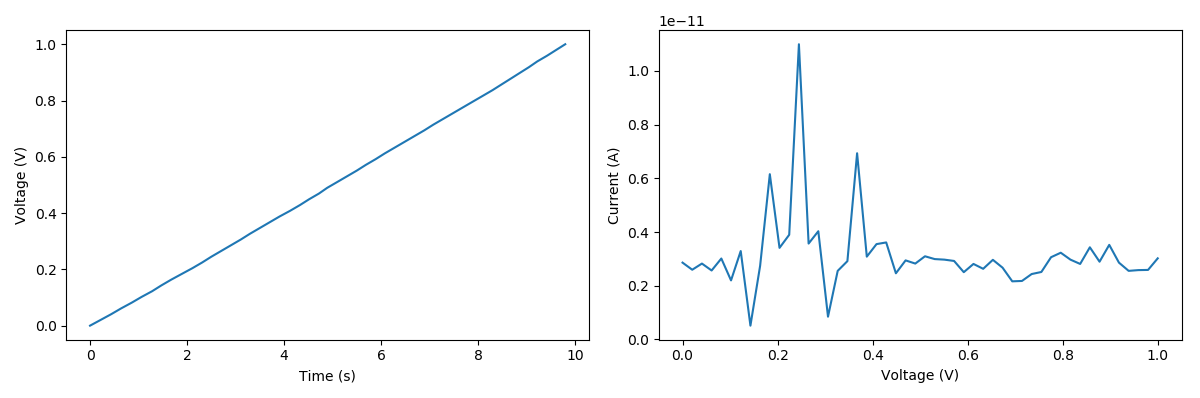

In [11]:
s = Sweep()
s.follow_param(Keith.curr)
s.sweep(Keith.volt, np.linspace(0, 1, 50), inter_delay=.01)

Now that we have created another "results" we can see the entire list of experiments and results in the database

In [12]:
qc.dataset.experiment_container.experiments()

[demotest3#my best sample3#1@C:\Users\nanouser\MeasureIt\currentdatabase.db
 --------------------------------------------------------------------------
 1-results-1-Keith_volt,time,Keith_curr-50]

We can look at previous data

In [14]:
ex = qc.dataset.experiment_container.load_experiment(0)
from qcodes.dataset.data_export import get_data_by_id 
fii = get_data_by_id(ex.data_sets()[0].run_id)

In [15]:
fii

[[{'name': 'Keith_volt',
   'label': 'Voltage',
   'unit': 'V',
   'data': array([ 0.        ,  0.02040816,  0.04081633,  0.06122449,  0.08163265,
           0.10204082,  0.12244898,  0.14285714,  0.16326531,  0.18367347,
           0.20408163,  0.2244898 ,  0.24489796,  0.26530612,  0.28571429,
           0.30612245,  0.32653061,  0.34693878,  0.36734694,  0.3877551 ,
           0.40816327,  0.42857143,  0.44897959,  0.46938776,  0.48979592,
           0.51020408,  0.53061224,  0.55102041,  0.57142857,  0.59183673,
           0.6122449 ,  0.63265306,  0.65306122,  0.67346939,  0.69387755,
           0.71428571,  0.73469388,  0.75510204,  0.7755102 ,  0.79591837,
           0.81632653,  0.83673469,  0.85714286,  0.87755102,  0.89795918,
           0.91836735,  0.93877551,  0.95918367,  0.97959184,  1.        ])},
  {'name': 'time',
   'label': 'Time',
   'unit': 's',
   'data': array([ 0.   ,  0.219,  0.437,  0.64 ,  0.859,  1.062,  1.281,  1.469,
           1.672,  1.89 ,  2.109,  2.3

In [16]:
fii[0][1]['data']

array([ 0.   ,  0.219,  0.437,  0.64 ,  0.859,  1.062,  1.281,  1.469,
        1.672,  1.89 ,  2.109,  2.312,  2.5  ,  2.703,  2.906,  3.109,
        3.297,  3.5  ,  3.703,  3.906,  4.125,  4.328,  4.515,  4.719,
        4.89 ,  5.094,  5.297,  5.5  ,  5.687,  5.89 ,  6.078,  6.281,
        6.484,  6.687,  6.89 ,  7.078,  7.281,  7.484,  7.687,  7.89 ,
        8.094,  8.297,  8.484,  8.672,  8.859,  9.047,  9.219,  9.422,
        9.609,  9.797])